In [1]:
import arcgis
import geoint

In [2]:
help(geoint)

Help on package geoint:

NAME
    geoint

DESCRIPTION
    # Copyright (C) 2020 Jan Tschada (gisfromscratch@live.de)
    #
    # This program is free software: you can redistribute it and/or modify
    # it under the terms of the GNU Lesser General Public License as published by
    # the Free Software Foundation, either version 3 of the License, or
    # (at your option) any later version.
    #
    # This program is distributed in the hope that it will be useful,
    # but WITHOUT ANY WARRANTY; without even the implied warranty of
    # MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    # GNU Lesser General Public License for more details.
    #
    # You should have received a copy of the GNU Lesser General Public License
    # along with this program.  If not, see <https://www.gnu.org/licenses/>.
    #

PACKAGE CONTENTS
    geospatial

FUNCTIONS
    create_bins(spatial_grid, latitudes, longitudes)
        Creates bins using a spatial grid and WGS84 coordinates.
    
 

# Create a rectangular spatial grid (500 km)

In [3]:
spatial_grid=geoint.create_spatial_grid(spacing_meters=5e5)

# Create a spatial aggregation using two point locations (Dessau and Bonn)

In [4]:
# Coordinates tuple (latitude, longitude)
# Coordinates arrays [latitude, ...], [longitude, ...]
dessau_coordinates = (51.83864, 12.24555)
bonn_coordinates = (50.73438, 7.09549)
latitudes = [dessau_coordinates[0], bonn_coordinates[0]]
longitudes = [dessau_coordinates[1], bonn_coordinates[1]]
grid_aggregation = geoint.create_bins(spatial_grid, latitudes, longitudes)

# Convert the spatial aggregation to a featureset

In [5]:
grid_featureset = grid_aggregation.to_featureset()

# Connect to ArcGIS Online anonymously

In [6]:
gis = arcgis.GIS()

# Visualize the spatial aggregation on a map

In [7]:
germany_map = gis.map('Germany')
germany_map.basemap = 'dark-gray-vector'

grid_featureset.sdf.spatial.plot(germany_map,
                                 renderer_type='c',  # for class breaks renderer
                                 method='esriClassifyNaturalBreaks',  # classification algorithm
                                 class_count=5,  # choose the number of classes
                                 col='hitCount',  # numeric column to classify
                                 cmap='coolwarm',  # color map to pick colors from for each class
                                 alpha=0.35  # specify opacity
                                )
germany_map

MapView(layout=Layout(height='400px', width='100%'))

# Use Case: Aggregate and Visualize ACLED events

In [18]:
import os
import pandas

acled_environ_key = 'acled.data.filepath'
if not acled_environ_key in os.environ:
    raise ValueError('Define an environment variable named \'%s\' and set the full qualified filepath to the *.csv file containing the ACLED events!' % (acled_environ_key))
    
acled_filepath = os.environ[acled_environ_key]
acled_data = pandas.read_csv(acled_filepath, encoding='utf_8')
acled_latitude_column = 'latitude'
acled_longitude_column = 'longitude'
if (not acled_latitude_column in acled_data.columns or not acled_longitude_column in acled_data.columns):
    raise ValueError('Latitude and Longitude columns must exists!')

latitudes = acled_data[acled_latitude_column]
longitudes = acled_data[acled_longitude_column]
grid_aggregation = geoint.create_bins(spatial_grid, latitudes, longitudes)
grid_featureset = grid_aggregation.to_featureset()

world_map = gis.map()
world_map.basemap = 'dark-gray-vector'

grid_featureset.sdf.spatial.plot(world_map,
                                 renderer_type='c',  # for class breaks renderer
                                 method='esriClassifyNaturalBreaks',  # classification algorithm
                                 class_count=5,  # choose the number of classes
                                 col='hitCount',  # numeric column to classify
                                 cmap='coolwarm',  # color map to pick colors from for each class
                                 alpha=0.35  # specify opacity
                                )
world_map

MapView(layout=Layout(height='400px', width='100%'))

In [9]:
#TODO Remove basemap
#world_map.basemap = ''

In [10]:
import tempfile

world_map.take_screenshot(False, False, os.path.join(tempfile.gettempdir(), 'spatial_bin.png'))

Cannot take screenshot if widget is not visible in notebook: Please try again when widget is visible.


False

## Show class breaks from first layer

Text(0.5,1,'Histogram of hit counts')

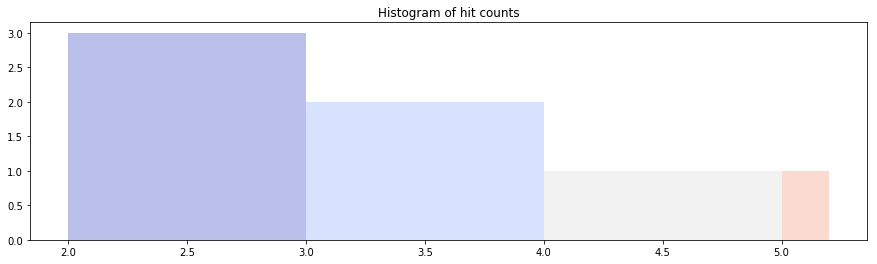

In [11]:
import matplotlib.pyplot as plt

class_breaks = world_map.layers[0].layer.layerDefinition.drawingInfo.renderer.classBreakInfos
max_values = []
colors = []
for class_break in class_breaks:
    max_values.append(class_break.classMaxValue)
    colors.append([color/255.0 for color in class_break.symbol.color])

# adjust bin for last class break
eps = 1e-1
max_values[-1] += 2*eps
    
# build a histogram for the same class breaks
plt.figure(figsize=(15,4))
n, bins, patches = plt.hist(grid_featureset.sdf['hitCount'], bins=max_values)

# apply the same color for each class to match the map
for patch, color in zip(patches, colors):
    patch.set_facecolor(color)
    
plt.title('Histogram of hit counts')

In [12]:
isin_toptwo = grid_featureset.sdf['hitCount']>=max_values[-3]
grid_featureset.sdf[isin_toptwo]

,hitCount,OBJECTID,SHAPE
2,4,3,"{""rings"": [[[3962492.1572117545, 5759028.54161..."
30,5,31,"{""rings"": [[[4962492.1572117545, 1259028.54161..."


## Calculate statistics

In [13]:
def print_value_counts(acled_data):
    print('Location:')
    print(acled_data['location'].value_counts())
    print()
    print('Country:')
    print(acled_data['country'].value_counts())
    print()
    print('Admin1:')
    print(acled_data['admin1'].value_counts())
    print()
    print('Admin2:')
    print(acled_data['admin2'].value_counts())
    print()
    print('Admin3:')
    print(acled_data['admin3'].value_counts())
    print()

print_value_counts(acled_data)

Location:
Jalandhar                 2
Chinari                   1
Ar-Ra'ee                  1
Semyhiria                 1
Mahoba                    1
Qurna                     1
Watamu                    1
Constantine               1
Aygedzor                  1
Villahermosa              1
Sertania                  1
Hong Kong-Kwai Tsing      1
Aslieh                    1
Wanju                     1
Aden-Community College    1
Balhaf                    1
Cuitzeo del Porvenir      1
Hong Kong-Tsuen Wan       1
Al Alam Military Camp     1
Al-Jurdi al-Gharbi        1
Amaravati                 1
Boeung Trabek             1
Xalapa-Enriquez           1
Taichung City-West        1
Nobili                    1
Al Mukalla                1
Amacuzac                  1
Changwon                  1
Lucknow                   1
San Jose de Ure           1
Man                       1
Ar Riyan                  1
Jabal Makhdarah           1
Viktorivka                1
Hazarin                   1
Kafr Nobol

In [14]:
acled_data_geodetailed = acled_data[acled_data['geo_precision'] == 1]
print_value_counts(acled_data_geodetailed)

Location:
Jalandhar                 2
Al Mukalla                1
Villahermosa              1
Qurna                     1
Watamu                    1
Constantine               1
Taichung City-West        1
Ciudad Juarez             1
Sertania                  1
Al-Jurdi al-Gharbi        1
Wanju                     1
Aden-Community College    1
Cuitzeo del Porvenir      1
Hong Kong-Tsuen Wan       1
Al Alam Military Camp     1
Boeung Trabek             1
Lucknow                   1
Aslieh                    1
Ar-Ra'ee                  1
Hong Kong-Kwai Tsing      1
Kafr Nobol                1
Changwon                  1
Xalapa-Enriquez           1
Mahoba                    1
Ar Riyan                  1
Balhaf                    1
Hazarin                   1
Man                       1
Amacuzac                  1
Huizucar                  1
Bhubaneswar               1
Warmahan                  1
Algiers                   1
Ataq                      1
Morinda                   1
Kolhapur  

In [45]:
from arcgis.features import GeoAccessor
from geoint import geospatial
def locations_in_areas(acled_data, latitudes, longitudes, area_data):
    with geospatial.geospatial_engine_factory.create_cloud_engine() as geospatial_engine:
        points = geospatial_engine.create_points(latitudes, longitudes)
        WGS84 = 4326
        WEB_MERCATOR = 3857
        mercator_points = geospatial_engine.project(points, WGS84, WEB_MERCATOR)
    
    grid_locations = []
    for index, area_row in area_data.iterrows():
        area_envelope = area_row['SHAPE'].envelope
        grid_location = { 
            'hitCount': area_row['hitCount'], 
            'locations': dict()
        }
        for index in range(0, len(mercator_points)):
            location = acled_data['location'][index]
            if not location in grid_location['locations']:
                mercator_point = mercator_points[index]
                if area_envelope.xmin <= mercator_point.x \
                and mercator_point.x <= area_envelope.xmax \
                and area_envelope.ymin <= mercator_point.y \
                and mercator_point.y <= area_envelope.ymax:
                    location_entry = {
                        'location': location,
                        'country': acled_data['country'][index],
                        'admin1': acled_data['admin1'][index],
                        'admin2': acled_data['admin2'][index],
                        'admin3': acled_data['admin3'][index],
                        'geometry': mercator_point
                    }
                    grid_location['locations'][location] = location_entry
                    
        grid_locations.append(grid_location)
    
    return grid_locations

area_data = grid_featureset.sdf.nlargest(3, 'hitCount')[['hitCount', 'SHAPE']]
locations_in_areas(acled_data, latitudes, longitudes, area_data)

[{'hitCount': 14893,
  'locations': {'Abakumov Mine': {'admin1': 'Donetsk',
    'admin2': 'Donetsk',
    'admin3': nan,
    'country': 'Ukraine',
    'geometry': {'x': 4189108.2858379954, 'y': 6105973.149019538},
    'location': 'Abakumov Mine'},
   'Aksay': {'admin1': 'Rostov Oblast',
    'admin2': 'Aksaysky',
    'admin3': nan,
    'country': 'Russia',
    'geometry': {'x': 4437384.146154233, 'y': 5985977.948297543},
    'location': 'Aksay'},
   'Almazna': {'admin1': 'Luhansk',
    'admin2': 'Stakhanov Municipality',
    'admin3': nan,
    'country': 'Ukraine',
    'geometry': {'x': 4294739.350651733, 'y': 6193888.484833642},
    'location': 'Almazna'},
   'Antratsit': {'admin1': 'Luhansk',
    'admin2': 'Antratsit',
    'admin3': nan,
    'country': 'Ukraine',
    'geometry': {'x': 4351623.610447095, 'y': 6126008.105755709},
    'location': 'Antratsit'},
   'Artema': {'admin1': 'Luhansk',
    'admin2': 'Stanychno-Luhansy',
    'admin3': nan,
    'country': 'Ukraine',
    'geometry':

In [51]:
help(grid_featureset.sdf.spatial)

Help on GeoAccessor in module arcgis.features.geo._accessor object:

class GeoAccessor(builtins.object)
 |  The DataFrame Accessor is a namespace that performs dataset operations.
 |  This includes visualization, spatial indexing, IO and dataset level properties.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, obj)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  distance_matrix(self, leaf_size=16, rebuild=False)
 |      Creates a k-d tree to calculate the nearest-neighbor problem.
 |      
 |      **requires scipy**
 |      
 |      ====================     ====================================================================
 |      **Argument**             **Description**
 |      --------------------     --------------------------------------------------------------------
 |      leafsize                 Optional Integer. The number of points at which the algorithm
 |                               switches over to brute-force. Default: 16.
 |    